<a href="https://colab.research.google.com/github/rybread1/image-super-resolution/blob/main/super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL.Image

In [22]:
def preprocess_image(image_path):
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]

  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def downscale_image(image, downscale_ratio=4):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // downscale_ratio, image_size[1] // downscale_ratio],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

def plot_image(image, title=""):
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [23]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model = hub.load(SAVED_MODEL_PATH)

In [62]:
img = preprocess_image('/content/kautz.jpg')
# img = downscale_image(np.squeeze(img), 12)

In [63]:
def preprocess_img_slice(img_slice):
  return tf.cast(tf.convert_to_tensor(np.expand_dims(img_slice, axis=0)), tf.float32)

def find_row_d(img, start=64):
  for i in range(start, 100000):
    if (img.shape[0] % i) == 0:
      return i

def find_col_d(img, start=60):
  for i in range(start, 100000):
    if (img.shape[1] % i) == 0:
      return i

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)


In [64]:
img_np = np.squeeze(img.numpy())

imgs = []

row_dim = find_row_d(img_np)
col_dim = find_col_d(img_np)

for r in range(0,img_np.shape[0],row_dim):
    for c in range(0,img_np.shape[1],col_dim):
        imgs.append(preprocess_img_slice(img_np[r:r+row_dim, c:c+col_dim,:]))

In [65]:
img_x_row = len(range(0,img_np.shape[1],col_dim))

In [66]:
sr_imgs = [model(i) for i in imgs]

In [67]:
img_rows = [np.squeeze(np.concatenate(sr_imgs[idx:idx+img_x_row], axis=2)) for idx in list(range(0, len(sr_imgs), img_x_row))]
enhanced_img = np.concatenate(img_rows, axis=0)

In [68]:
save_image(np.squeeze(img), 'og_img.png')
save_image(np.squeeze(enhanced_img), 'sr_img.png')

Saved as og_img.png.jpg
Saved as sr_img.png.jpg


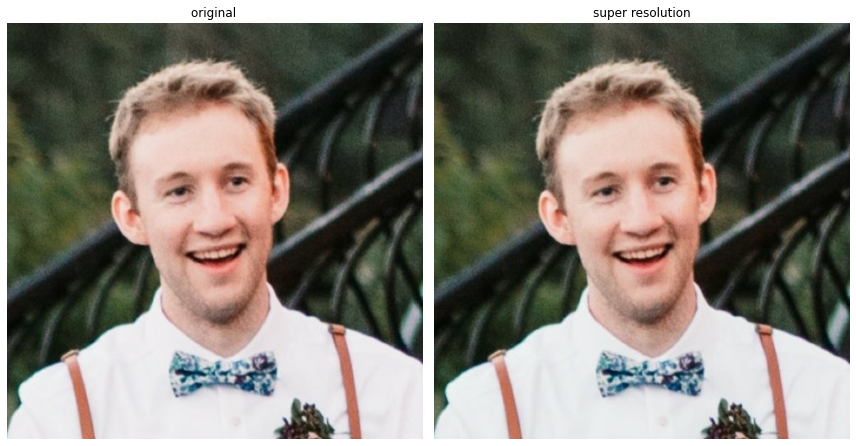

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
plt.subplot(122)
plot_image(np.squeeze(enhanced_img), 'super resolution')
plt.subplot(121)
plot_image(np.squeeze(img), 'original ')

plt.tight_layout()

In [70]:
img.shape

TensorShape([1, 468, 468, 3])

In [71]:
enhanced_img.shape

(1872, 1872, 3)